In [1]:
#!pip install pvporcupine
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Resample
import torchaudio
import librosa
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import numpy as np
import librosa
import logging
import soundfile
import torch.nn.functional as F
import csv
import tqdm

In [2]:
class AudioDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        audio_path = self.data_frame['path'][idx]
        label = self.data_frame['label'][idx]

        return audio_path, label

In [3]:
#
import pvporcupine
import struct
import wave

def test_porcupine(audio_file_path):
    # Create a Porcupine instance with the built-in keyword.
    porcupine = pvporcupine.create(
        access_key='FB7jo4vQwScNqXa5J2E+/nCXw3wag8lSs4oj6RpfnJCK6NZopYcxSg==',
    keyword_paths=['/home/ai01/Desktop/marin_work_folder/Hey-Jules_en_linux_v3_0_0.ppn'],
    sensitivities=[0.99]
  )

    try:
        # Open the audio file.
        wf = wave.open(audio_file_path, 'rb')

        print(wf)
        # Process the audio stream.
        num_frames = int(porcupine.frame_length * 3 * wf.getframerate() / porcupine.frame_length)
        #print(num_frames)
        frames = wf.readframes(num_frames)

        pcm = struct.unpack_from("h" * porcupine.frame_length, frames, 0)
        #print(len(pcm))
        #print(pcm)
        result = porcupine.process(pcm)
        if result >= 0:
            print(f"Keyword detected at frame {result}")
        else:
            print("Keyword not detected.")
    finally:
        # Clean up the Porcupine instance.
        porcupine.delete()
        wf.close()

# Example usage
#audio_file_path='/home/ai01/Desktop/marin_work_folder/heyjules/generated-voxCelebVOL2-p262.wav'
#test_porcupine(audio_file_path)


In [4]:
import pvporcupine
import struct
import wave

def process_audio(porcupine, wf):
    # Buffer to hold audio data
    audio_buffer = bytes()
    total_frames_processed = 0

    while True:
        # Read data from the file
        data = wf.readframes(porcupine.frame_length)
        if len(data) == 0:
            break  # End of file

        # Append data to buffer
        audio_buffer += data

        # Check if buffer has enough data to process
        if len(audio_buffer) >= porcupine.frame_length * 2:  # 2 bytes per frame (16-bit audio)
            # Process the audio in frame_length chunks
            pcm = struct.unpack_from("h" * porcupine.frame_length, audio_buffer, 0)
            result = porcupine.process(pcm)
            if result >= 0:
                return result
            
            # Move the buffer forward
            audio_buffer = audio_buffer[porcupine.frame_length * 2:]
            total_frames_processed += porcupine.frame_length

    # Process any remaining audio data by padding if necessary
    if len(audio_buffer) > 0:
        padded_pcm = struct.unpack_from("h" * porcupine.frame_length, audio_buffer + b'\x00' * (porcupine.frame_length * 2 - len(audio_buffer)), 0)
        result = porcupine.process(padded_pcm)
        if result >= 0:
            return result
    return -1
    
def process(file_path,thresh):
    porcupine = pvporcupine.create(
               access_key='FB7jo4vQwScNqXa5J2E+/nCXw3wag8lSs4oj6RpfnJCK6NZopYcxSg==',
    keyword_paths=['/home/ai01/Desktop/marin_work_folder/Hey-Jules_en_linux_v3_0_0.ppn'],
    sensitivities=[thresh]
    )

    wf = wave.open(file_path, 'rb')
    val=process_audio(porcupine, wf)
    return val


# Example usage
#audio_file_path = '/home/ai01/Desktop/marin_work_folder/test_clean/negative/generated-train_empire.wav'

#process(audio_file_path,0.03)


In [7]:
import numpy as np
import tqdm
import pandas as pd

def run(hparams):
    test_file=pd.read_csv(hparams['test_csv_file'])
    test_dataset = AudioDataset(csv_file=test_file)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    thresholds = np.arange(0.03, 1.01, 0.03)
    tp = np.zeros_like(thresholds)
    fp = np.zeros_like(thresholds)
    fn = np.zeros_like(thresholds)
    tn = np.zeros_like(thresholds)
    testing_csv_file=hparams['test_csv_file']
    for path, labels in tqdm.tqdm(test_loader):
        #print(path)
        for idx, thresh in enumerate(thresholds):
            pred=process(path[0],thresh)+1
            labels = labels.int()
            tp[idx] += ((pred == 1) & (labels == 1)).sum().item()
            fp[idx] += ((pred == 1) & (labels == 0)).sum().item()
            fn[idx] += ((pred == 0) & (labels == 1)).sum().item()
            tn[idx] += ((pred == 0) & (labels == 0)).sum().item()
    
    
    # Calculate metrics needed for DET curve
    far = fp / (fp + tn)  # False Alarm Rate
    frr = fn / (fn + tp)  # False Rejection Rate (Miss Rate)

    return {'Thresholds': thresholds, 'FAR': far, 'FRR': frr}

In [8]:
def export_metrics_to_csv(metrics, filename):
    df = pd.DataFrame(metrics)
    df.to_csv(filename, index=False)
    print(f"Metrics exported successfully to {filename}")

hparams={
    'test_csv_file':'/home/ai01/Desktop/marin_work_folder/train_code/metadata_test_clean.csv',
}

metrics=run(hparams)
export_metrics_to_csv(metrics, 'test_metrics_porcupine_clean.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1135/1135 [09:30<00:00,  1.99it/s]

Metrics exported successfully to test_metrics_porcupine_clean.csv


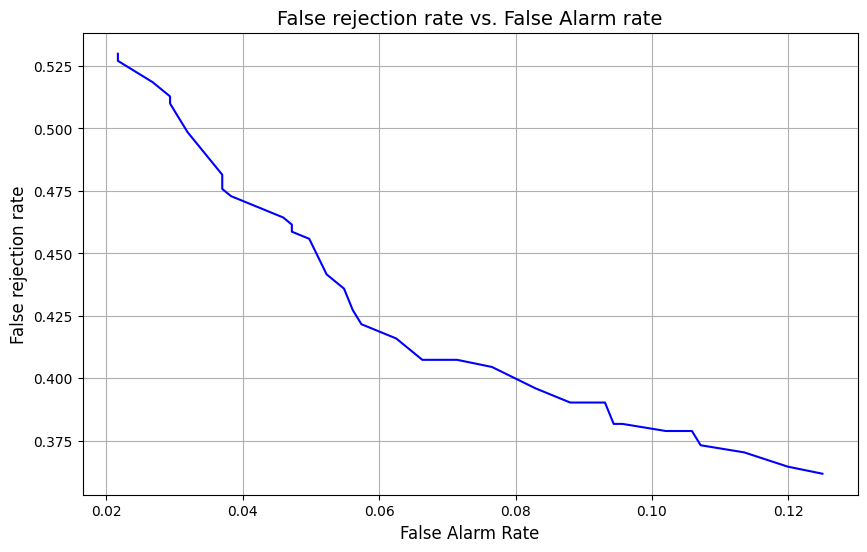

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(metrics['FAR'], metrics['FRR'], marker=None,color='blue')  # Line plot with markers
plt.xlabel('False Alarm Rate', fontsize=12)
plt.ylabel('False rejection rate', fontsize=12)
plt.title('False rejection rate vs. False Alarm rate', fontsize=14)
plt.grid(True)
plt.show()